## Camera calibration and undistortion

Calibrate the camera using provided images in `camera_cal` directory.
Pickup a single image in the `camera_cal` directory and see undistortion works well.

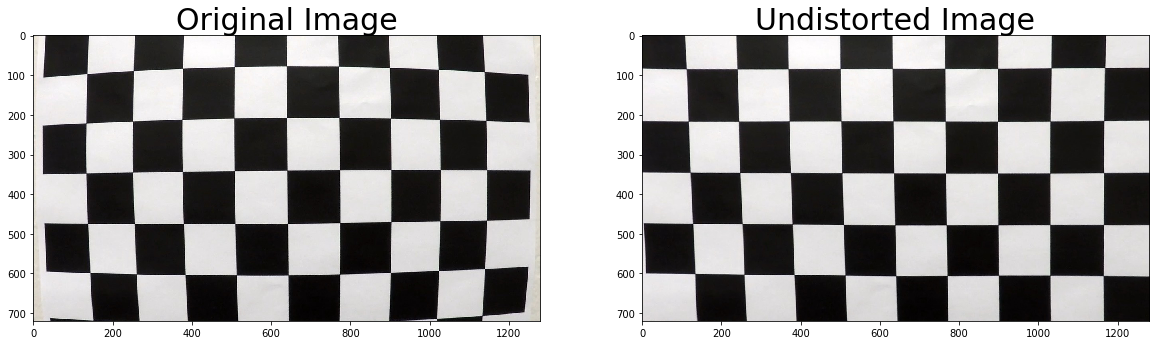

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import pickle

import matplotlib.image as mpimg
%matplotlib inline

nx = 9
ny = 5

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,4,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration1*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)

        
# Save mtx, dist
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "./calibration_result/calibration_result_pickle.p", "wb" ) )

# Check result with a single image.
sample = mpimg.imread('./camera_cal/calibration1.jpg')
sample_undist = cv2.undistort(sample, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(sample)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(sample_undist)
ax2.set_title('Undistorted Image', fontsize=30)

## Apply undistortion to test images

Apply undistortion with the calibration parameters obtained in previous steps.
After the undistortion, choose four coners to execute perspective transform.

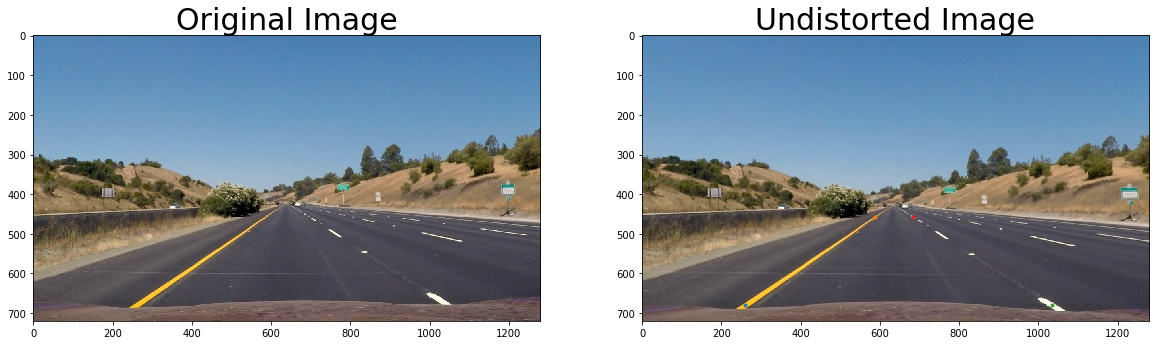

In [2]:
img = mpimg.imread('./test_images/straight_lines1.jpg')
c_result = pickle.load(open('calibration_result/calibration_result_pickle.p','rb'))
mtx = c_result['mtx']
dist = c_result['dist']

undist = cv2.undistort(img, mtx, dist, None, mtx)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)

#mpimg.imsave('./output_images/undist_straight_lines1.jpg', undist)

src_bottom_left = [261.0, 680.0]
src_upper_left = [588.0, 457.0]
src_bottom_right = [1034.0, 680.0]
src_upper_right = [684.0, 457.0]
ax2.plot(src_bottom_left[0], src_bottom_left[1], '.')
ax2.plot(src_upper_left[0], src_upper_left[1], '.')
ax2.plot(src_bottom_right[0], src_bottom_right[1], '.')
ax2.plot(src_upper_right[0], src_upper_right[1], '.')

## Perspective transform
Execute perspective transform.

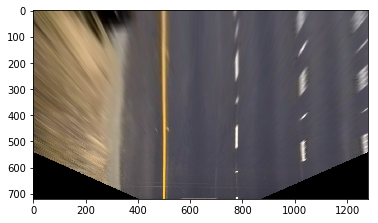

In [3]:
src = np.float32([
    src_bottom_left,
    src_upper_left,
    src_bottom_right,
    src_upper_right
])

dst_bottom_left = [500, 720]
dst_upper_left = [500,0]
dst_bottom_right = [780, 720]
dst_upper_right = [780, 0]
dst = np.float32([
    dst_bottom_left,
    dst_upper_left,
    dst_bottom_right,
    dst_upper_right
])

M = cv2.getPerspectiveTransform(src, dst)
img_size = (undist.shape[1], undist.shape[0])
warped = cv2.warpPerspective(undist, M, img_size)
plt.imshow(warped)

In [4]:
def prepare_image(image):
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    img_size = (undist.shape[1], undist.shape[0])
    warped = cv2.warpPerspective(undist, M, img_size)
    return warped

## Apply undistortion/ perspective transfrom to all test images.

Apply undistortion, perspective transfrom to all test images provided in `test_images` directory.

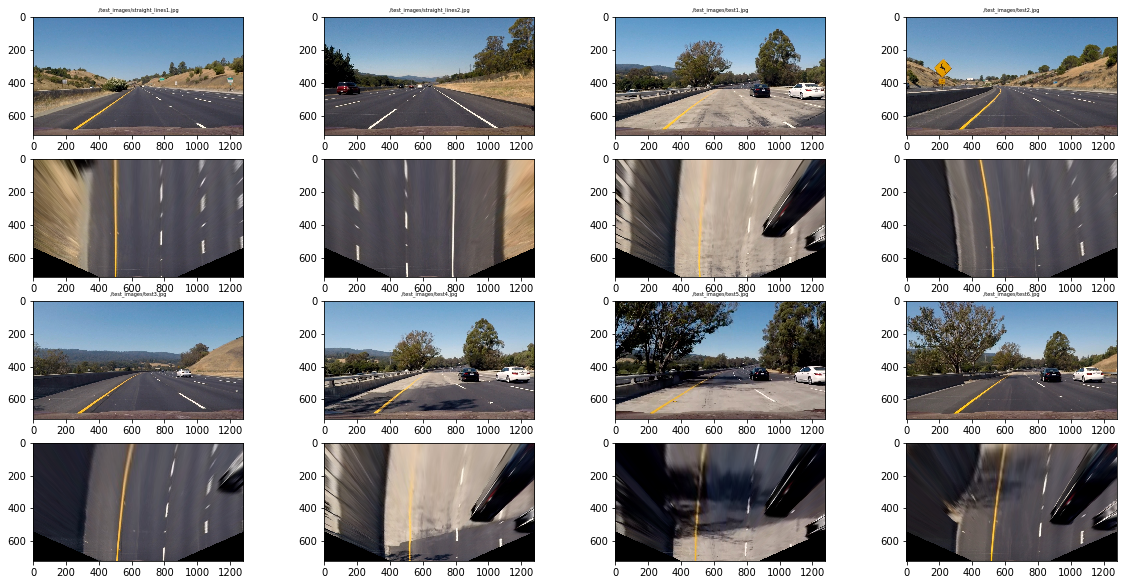

In [5]:
test_images = glob.glob('./test_images/*.jpg')

f, subs = plt.subplots(4, 4, figsize=(20,10))
for idx, fname in enumerate(test_images):
#    image = cv2.imread(fname)
    image = mpimg.imread(fname)
    warped = prepare_image(image)
    if 0 <= idx and idx <= 3:
        subOrig = subs[0][idx]
        sub = subs[1][idx]
    else:
        subOrig = subs[2][idx%4]
        sub = subs[3][idx%4]
    sub.imshow(warped)
    subOrig.set_title(fname, fontsize=5)
    subOrig.imshow(image)

In [14]:
def convert_color(img, s_thresh=(100, 245), sx_thresh=(130, 255)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=31) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    (R,G,B) = cv2.split(img)
    dark_thresh = 50
    s_binary[(R<dark_thresh) & (G<dark_thresh) & (B<dark_thresh)] = 0

    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    # Remove side images
    combined_binary[:, 0:280] = 0
    combined_binary[:, 1000:] = 0

    return combined_binary

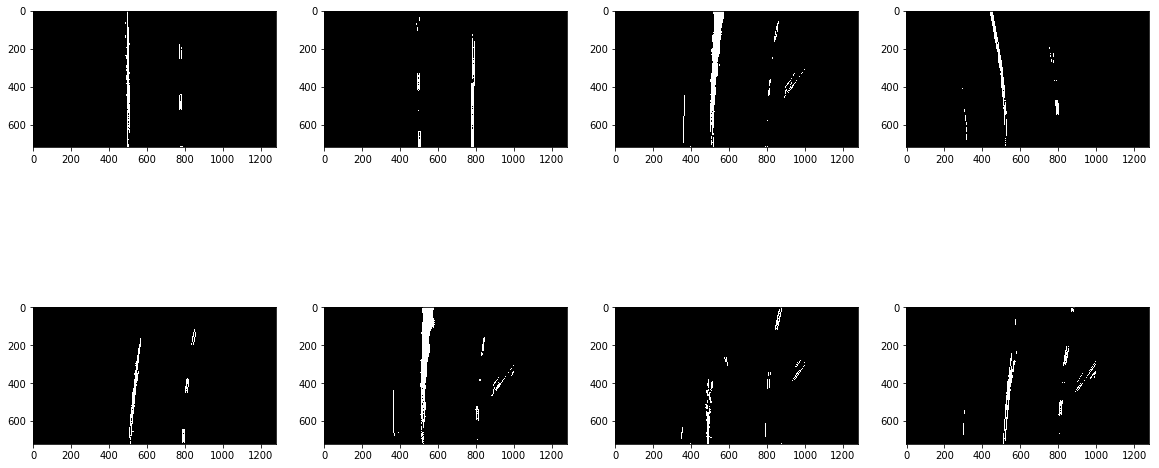

In [15]:
f, subs = plt.subplots(2, 4, figsize=(20,10))
for idx, fname in enumerate(test_images):
    image = cv2.imread(fname)
    warped = prepare_image(image)
    converted = convert_color(warped)
    
    if 0 <= idx and idx <= 3:
        subs[0][idx].imshow(converted, cmap='gray')
    else:
        subs[1][idx%4].imshow(converted, cmap='gray')

In [8]:
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(warped, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids


def find_lane(warped):
    window_centroids = find_window_centroids(warped, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
    return output

In [45]:
def find_lane2(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
#    minpix = 50
    minpix = 1000
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = (\
                          (nonzeroy >= win_y_low) & \
                          (nonzeroy < win_y_high) & \
                          (nonzerox >= win_xleft_low) & \
                          (nonzerox < win_xleft_high)\
                         ).nonzero()[0]
        good_right_inds = (\
                           (nonzeroy >= win_y_low) & \
                           (nonzeroy < win_y_high) & \
                           (nonzerox >= win_xright_low) & \
                           (nonzerox < win_xright_high)\
                          ).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return (out_img, left_fitx, right_fitx, ploty, (leftx, lefty, rightx, righty))

In [46]:
def calculate_curvature(leftx, lefty, rightx, righty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return (left_curverad, right_curverad)

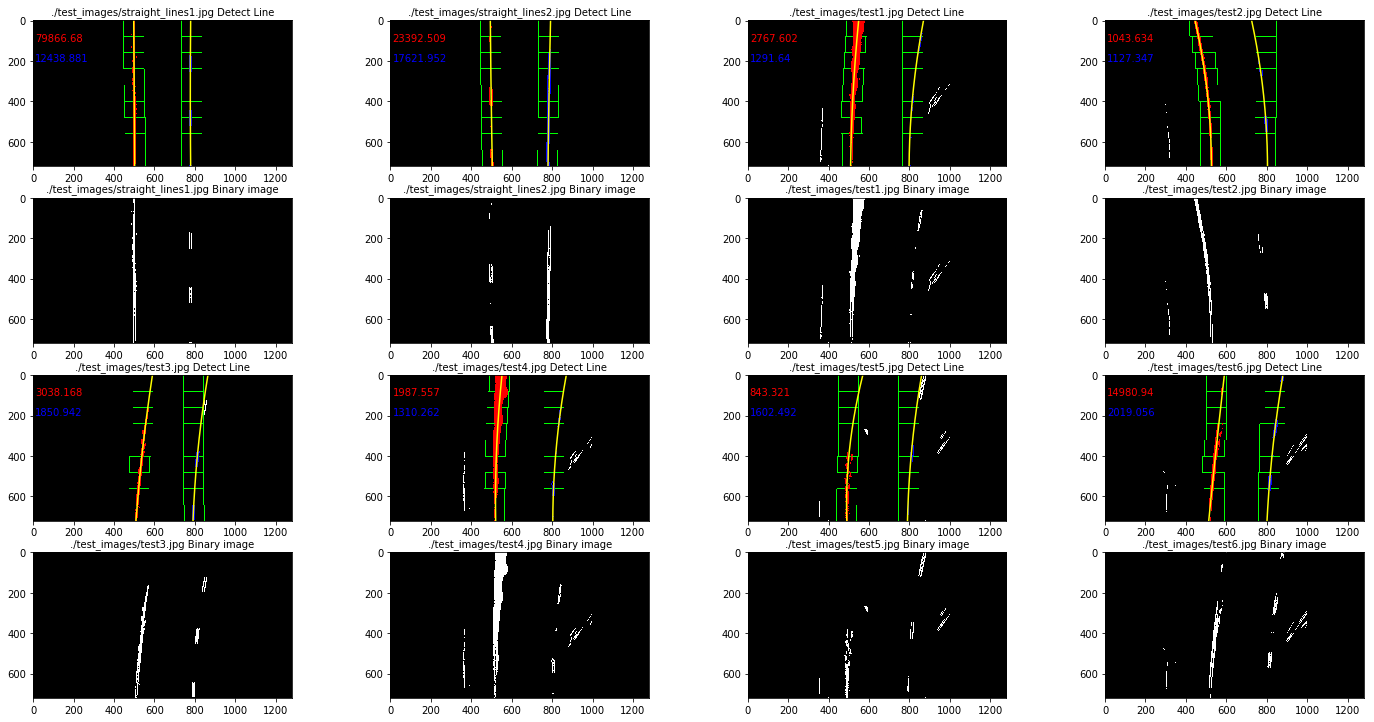

In [62]:
f, subs = plt.subplots(4, 4, figsize=(20,10))
plt.tight_layout()
for idx, fname in enumerate(test_images):
    image = cv2.imread(fname)
    warped = prepare_image(image)
    #converted = convert_color(warped, s_thresh=(100, 245), sx_thresh=(130, 255))
    converted = convert_color(warped)
    params = find_lane2(converted)

    curves = calculate_curvature(params[4][0],params[4][1],params[4][2],params[4][3])
    if 0 <= idx and idx <= 3:
        sub = subs[0][idx]
        subBin = subs[1][idx]
    else:
        sub = subs[2][idx%4]
        subBin = subs[3][idx%4]

    subBin.imshow(converted, cmap='gray')
    subBin.set_title(fname + " Binary image", fontsize=10)
    sub.imshow(params[0])
    sub.plot(params[1], params[3], color='yellow')
    sub.plot(params[2], params[3], color='yellow')
    sub.set_title(fname + " Detect Line", fontsize=10)

    sub.text(10, 100, str(round(curves[0],3)) , color="red")
    sub.text(10, 200, str(round(curves[1],3)) , color="blue")

## Check histgram (Remove it)

In [ ]:
f, subs = plt.subplots(2, 4, figsize=(20,10))
for idx, fname in enumerate(test_images):
    image = cv2.imread(fname)
    warped = prepare_image(image)
    converted = convert_color(warped, s_thresh=(140, 245), sx_thresh=(100, 255))
    histogram = np.sum(converted[converted.shape[0]//2:,:], axis=0)

    if 0 <= idx and idx <= 3:
        sub = subs[0][idx]
    else:
        sub = subs[1][idx%4]

    sub.set_title(fname, fontsize=10)
    sub.plot(histogram)